In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import random

%matplotlib inline

In [2]:
data = pd.read_csv("classification_data_HWK2/EMGaussian.data", header=None, delim_whitespace=True)
n_data = data.shape[0]
test = pd.read_csv("classification_data_HWK2/EMGaussian.test", header=None, delim_whitespace=True)
n_test= test.shape[0]
d = 2
K = 4

In [3]:
data_to_2d_array = np.empty((n_data, d))
for i in range(n_data):
    for j in range(d):
        data_to_2d_array[i, j] = data[j][i]

In [4]:
test_to_2d_array = np.empty((n_test, d))
for i in range(n_test):
    for j in range(d):
        test_to_2d_array[i, j] = test[j][i]

In [5]:
def draw_gaussian_contour(sigma, mu, iteration):
    delta = 0.025
    x = np.arange(-10.0, 8.0, delta)
    y = np.arange(-15.0, 15.0, delta)
    X, Y = np.meshgrid(x, y)

    Z1 = mlab.bivariate_normal(X, Y, np.sqrt(sigma[0][0][0]), np.sqrt(sigma[0][1][1]), mu[0, 0], mu[1, 0], sigma[0][0][1])
    Z2 = mlab.bivariate_normal(X, Y, np.sqrt(sigma[1][0][0]), np.sqrt(sigma[1][1][1]), mu[0, 1], mu[1, 1], sigma[1][0][1])
    Z3 = mlab.bivariate_normal(X, Y, np.sqrt(sigma[2][0][0]), np.sqrt(sigma[2][1][1]), mu[0, 2], mu[1, 2], sigma[2][0][1])
    Z4 = mlab.bivariate_normal(X, Y, np.sqrt(sigma[3][0][0]), np.sqrt(sigma[3][1][1]), mu[0, 3], mu[1, 3], sigma[3][0][1])
    plt.figure()
    CS1 = plt.contour(X, Y, Z1, colors='b')
    plt.clabel(CS1, inline=1, fontsize=10) 
    CS2 = plt.contour(X, Y, Z2, colors='c')
    plt.clabel(CS2, inline=1, fontsize=10)
    CS3 = plt.contour(X, Y, Z3, colors='y')
    plt.clabel(CS3, inline=1, fontsize=10)
    CS4 = plt.contour(X, Y, Z4, colors='r')
    plt.clabel(CS4, inline=1, fontsize=10)
    plt.title('Contours of the Gaussians at iteration ' + str(iteration))

# 4.(a) K-means algorithm

In [6]:
def assignCluster(mu, K, data, n_data):
    z = np.zeros(n_data, dtype=int)
    for i in range(n_data):
        dist_min = np.linalg.norm(np.array([data[0][i], data[1][i]]) - np.array(mu[0, :])[0])
        for k in range(K):
            dist = np.linalg.norm(np.array([data[0][i], data[1][i]]) - np.array(mu[k, :])[0])
            if dist < dist_min:
                dist_min = dist
                z[i] = int(k)
    return z

def updateCenter(z, K, d, data, n_data):
    count = np.zeros(K)
    mu = np.matrix(np.zeros((K, d)))
    for i in range(n_data):
        count[z[i]] += 1
        for dd in range(d):
            mu[z[i], dd] += data[dd][i]
    for k in range(K):
        for dd in range(d):
            if count[k] != 0:
                mu[k, dd] /= count[k]
    return mu

def kmeans(steps, K, d, data, n_data):
    mu = np.matrix(np.zeros((K, d)))
    for t in range(steps):
        z = assignCluster(mu, K, data, n_data)
        mu = updateCenter(z, K, d, data, n_data)
    return z, mu

In [7]:
z_kmeans_10, mu_kmeans_10 = kmeans(10, K, d, data, n_data)

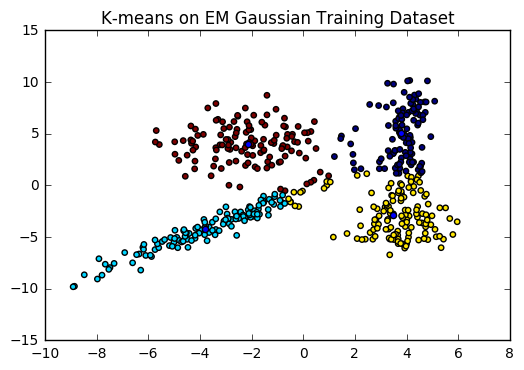

In [8]:
plt.scatter(data[0], data[1], s = 15, c = z_kmeans_10 / float(3))
plt.scatter(mu_kmeans_10[:, 0], mu_kmeans_10[:, 1], s = 20) # centers in blue
plt.title("K-means on EM Gaussian Training Dataset")
plt.show()

# EM-algorithm: Preliminaries

In [9]:
def logsumexp(v):
    """
    Log sum exponential computation
    
    Parameters
    ----------
    v: `numpy.array`, vector of negative integers
    
    Returns
    -------
    `float`, log(sum(exp(v)))
    """
    max_v = max(v)
    new_v = np.empty((len(v)))
    for i in range(len(v)):
        new_v[i] = v[i] - max_v
    return max_v + np.log(sum(np.exp(new_v)))

In [10]:
def li(x, pi, mu, sigma):
    """
    Parameters
    ----------
    x: `numpy.array`
    pi: `float`
    mu: `numpy.matrix`, a column matrix, same length as x
    sigma: `numpy.matrix`, positive definite matrix
    
    Returns
    -------
    `float`, log(pi Normal(x; mu, sigma))
    """
    d = len(x)
    x_temp = np.matrix(x.reshape(d, 1)) - mu
    sigma_inv = np.linalg.inv(sigma)
    return np.log(pi) - 0.5 * d * np.log(2 * np.pi) - 0.5 * sum(np.log(np.linalg.eigvals(sigma))) - 0.5 * (x_temp.transpose() * sigma_inv * x_temp)[0, 0]

In [11]:
def gamma(x, pi, mu, sigma):
    """
    Parameters
    ----------
    x: `numpy.array`, length = d
    pi: `numpy.array`, length = K
    mu: `numpy.matrix` 2d, mu[:,i] = ith column, shape = (d, K)
    sigma: `np.array of numpy.matrix` 3d, shape = (K, d, d)
    
    Returns
    -------
    `float`, sum_{j = 1}^{K} pi_j Normal(x; mu_j, sigma_j)
    `numpy.array`, the ith term  = pi_i Normal(x; mu_i, sigma_i) / sum_{j = 1}^{K} pi_j Normal(x; mu_j, sigma_j)
    """
    K = len(sigma)
    l = np.empty(K)
    for i in range(K):
        l[i] = li(x, pi[i], mu[:, i], np.matrix(sigma[i]))
    logsum = logsumexp(l)
    
    result = np.empty(K)
    for i in range(K):
        result[i] = np.exp(l[i] - logsum)
    return np.exp(logsum), result

### Initialization

In [12]:
def generate_unit_vector(K):
    result = np.random.rand(K)
    return result / sum(result)

In [13]:
pi_0 = generate_unit_vector(K)

In [14]:
def generate_identity_matrices(d, K):
    result = np.empty((K, d, d))
    for i in range(K):
        result[i] = np.eye(d)
    return result

In [15]:
sigma_0 = generate_identity_matrices(d, K)

In [16]:
mu_0 = mu_kmeans_10.transpose()

# 4.(b) EM-algorithm for a Gaussian mixture.
## Special Case: Covariance matrices proportional to the identity.

In [17]:
def EM_iterate_once_special(data, pi_current, mu_current, sigma_current):
    N = len(data)
    K = len(pi_current)
    d = mu_current.shape[0]
    gamma_K_N = np.empty((K, N))
    for n in range(N):
        gamma_K_N[:,n] = gamma(data[n], pi_current, mu_current, sigma_current)[1]
    
    gamma_sum_K = np.empty(K)
    for i in range(K):
        gamma_sum_K[i] = sum(gamma_K_N[i])
    
    pi_new = np.empty(K)
    for i in range(K):
        pi_new[i] = 1. / N * gamma_sum_K[i]
    
    mu_new = np.dot(np.matrix(gamma_K_N), np.matrix(data)).transpose()
    for i in range(K):
        mu_new[:,i] /= gamma_sum_K[i]
    
    alpha_new = np.zeros(K)
    for i in range(K):
        for n in range(N):
            x_temp = np.matrix(data[n].reshape(d, 1)) - mu_new[:,i]
            alpha_new[i] += gamma_K_N[i][n] * (x_temp.transpose() * x_temp) [0, 0] / d
        alpha_new[i] /= gamma_sum_K[i]

    sigma_new = np.zeros((K, d, d))
    for i in range(K):
        for dd in range(d):
            sigma_new[i, dd, dd] = alpha_new[i]
        
    return pi_new, mu_new, sigma_new 

In [18]:
def EM_iterate_special(data, pi_current, mu_current, sigma_current, n_iteration):
    pi_before, mu_before, sigma_before = pi_current, mu_current, sigma_current
    for j in range(n_iteration):
        pi_after, mu_after, sigma_after = EM_iterate_once_special(data, pi_before, mu_before, sigma_before)
        pi_before, mu_before, sigma_before = pi_after, mu_after, sigma_after
    return pi_before, mu_before, sigma_before

### Iteration

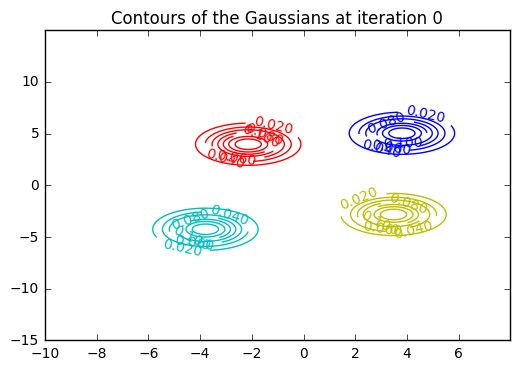

In [19]:
draw_gaussian_contour(sigma_0, mu_0, 0)

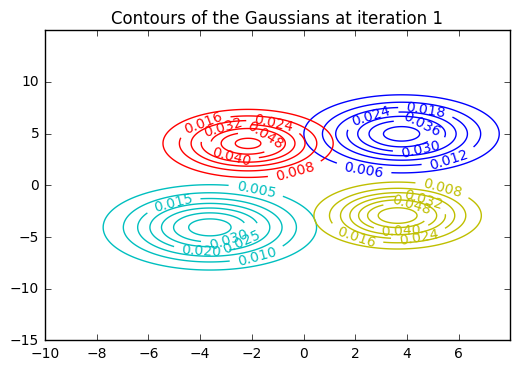

In [20]:
pi_1_special, mu_1_special, sigma_1_special = EM_iterate_once_special(data_to_2d_array, pi_0, mu_0, sigma_0)
draw_gaussian_contour(sigma_1_special, mu_1_special, 1)

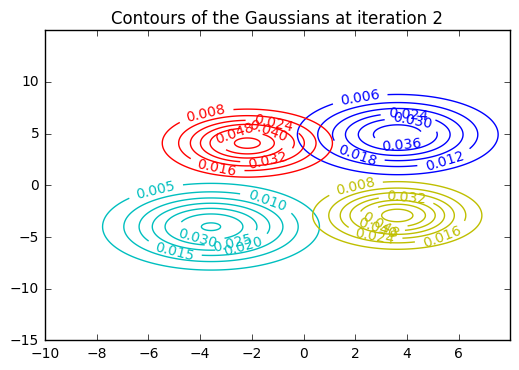

In [21]:
pi_2_special, mu_2_special, sigma_2_special = EM_iterate_once_special(data_to_2d_array, pi_1_special, mu_1_special, sigma_1_special)
draw_gaussian_contour(sigma_2_special, mu_2_special, 2)

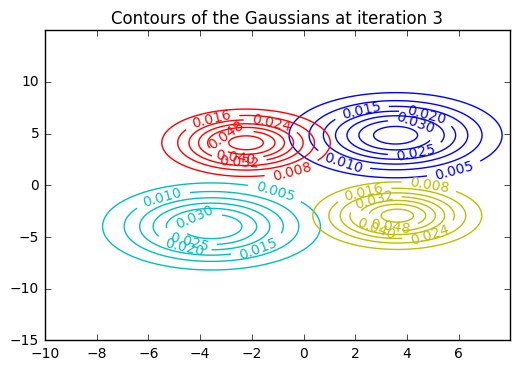

In [22]:
pi_3_special, mu_3_special, sigma_3_special = EM_iterate_once_special(data_to_2d_array, pi_2_special, mu_2_special, sigma_2_special)
draw_gaussian_contour(sigma_3_special, mu_3_special, 3)

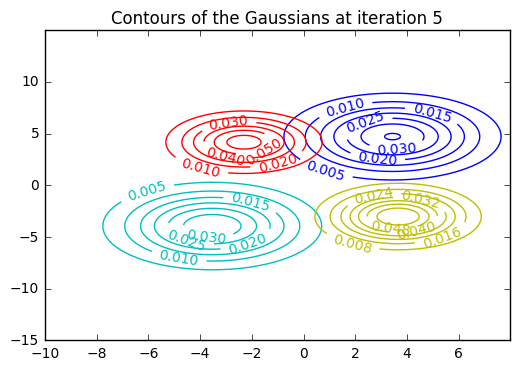

In [23]:
pi_5_special, mu_5_special, sigma_5_special = EM_iterate_special(data_to_2d_array, pi_3_special, mu_3_special, sigma_3_special, 2)
draw_gaussian_contour(sigma_5_special, mu_5_special, 5)

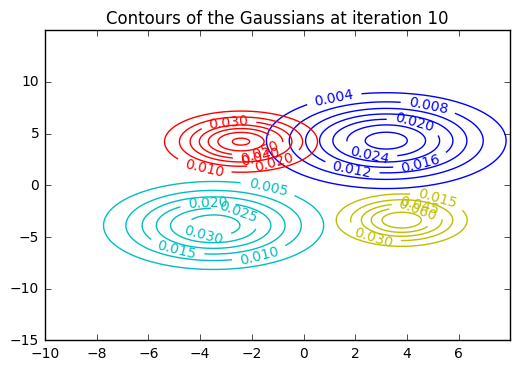

In [24]:
pi_10_special, mu_10_special, sigma_10_special = EM_iterate_special(data_to_2d_array, pi_5_special, mu_5_special, sigma_5_special, 5)
draw_gaussian_contour(sigma_10_special, mu_10_special, 10)

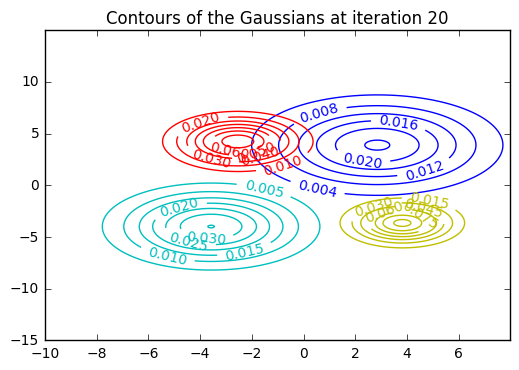

In [25]:
pi_20_special, mu_20_special, sigma_20_special = EM_iterate_special(data_to_2d_array, pi_10_special, mu_10_special, sigma_10_special, 10)
draw_gaussian_contour(sigma_20_special, mu_20_special, 20)

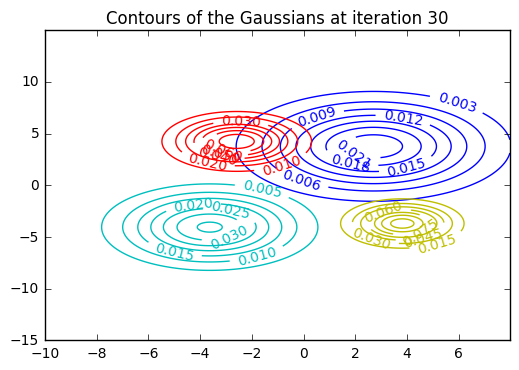

In [26]:
pi_30_special, mu_30_special, sigma_30_special = EM_iterate_special(data_to_2d_array, pi_20_special, mu_20_special, sigma_20_special, 10)
draw_gaussian_contour(sigma_30_special, mu_30_special, 30)

# 4.(c) EM-algorithm for a Gaussian mixture.
## General Case.

In [27]:
def EM_iterate_once(data, pi_current, mu_current, sigma_current):
    N = len(data)
    K = len(pi_current)
    d = mu_current.shape[0]
    gamma_K_N = np.empty((K, N))
    for n in range(N):
        gamma_K_N[:,n] = gamma(data[n], pi_current, mu_current, sigma_current)[1]
    
    gamma_sum_K = np.empty(K)
    for i in range(K):
        gamma_sum_K[i] = sum(gamma_K_N[i])
    
    pi_new = np.empty(K)
    for i in range(K):
        pi_new[i] = 1. / N * gamma_sum_K[i]
    
    mu_new = np.dot(np.matrix(gamma_K_N), np.matrix(data)).transpose()
    for i in range(K):
        mu_new[:,i] /= gamma_sum_K[i]
    
    sigma_new = np.zeros((K, d, d))
    for i in range(K):
        for n in range(N):
            x_temp = np.matrix(data[n].reshape(d, 1)) - mu_new[:,i]
            sigma_new[i] += gamma_K_N[i][n] * x_temp * x_temp.transpose()
        sigma_new[i] /= gamma_sum_K[i]
        
    return pi_new, mu_new, sigma_new   

In [28]:
def EM_iterate(data, pi_current, mu_current, sigma_current, n_iteration):
    pi_before, mu_before, sigma_before = pi_current, mu_current, sigma_current
    for j in range(n_iteration):
        pi_after, mu_after, sigma_after = EM_iterate_once(data, pi_before, mu_before, sigma_before)
        pi_before, mu_before, sigma_before = pi_after, mu_after, sigma_after
    return pi_before, mu_before, sigma_before

### Iteration

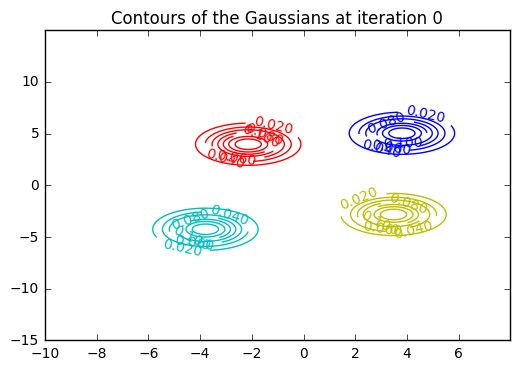

In [29]:
draw_gaussian_contour(sigma_0, mu_0, 0)

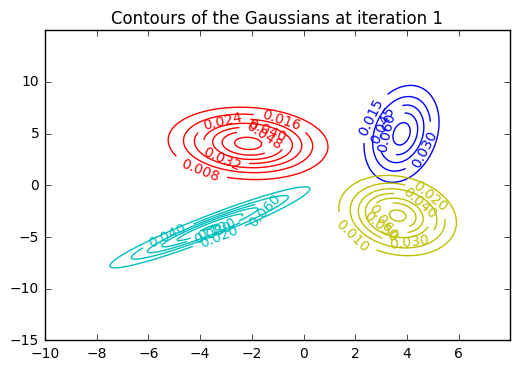

In [30]:
pi_1, mu_1, sigma_1 = EM_iterate_once(data_to_2d_array, pi_0, mu_0, sigma_0)
draw_gaussian_contour(sigma_1, mu_1, 1)

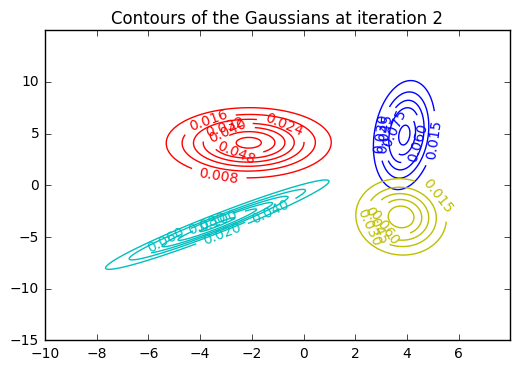

In [31]:
pi_2, mu_2, sigma_2 = EM_iterate_once(data_to_2d_array, pi_1, mu_1, sigma_1)
draw_gaussian_contour(sigma_2, mu_2, 2)

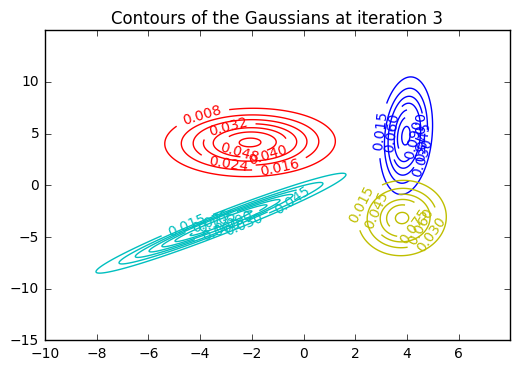

In [32]:
pi_3, mu_3, sigma_3 = EM_iterate_once(data_to_2d_array, pi_2, mu_2, sigma_2)
draw_gaussian_contour(sigma_3, mu_3, 3)

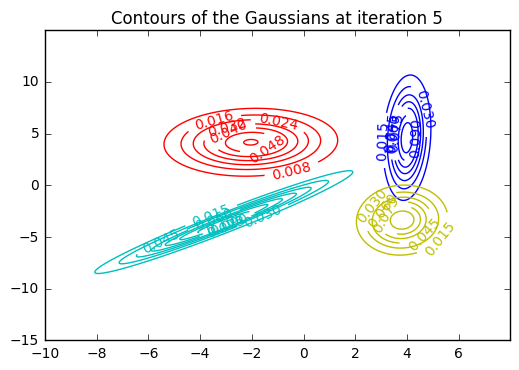

In [33]:
pi_5, mu_5, sigma_5 = EM_iterate(data_to_2d_array, pi_3, mu_3, sigma_3, 2)
draw_gaussian_contour(sigma_5, mu_5, 5)

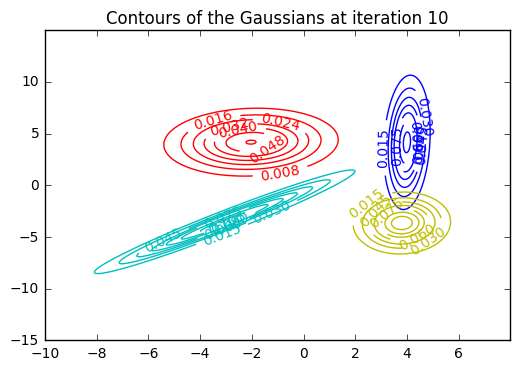

In [34]:
pi_10, mu_10, sigma_10 = EM_iterate(data_to_2d_array, pi_5, mu_5, sigma_5, 5)
draw_gaussian_contour(sigma_10, mu_10, 10)

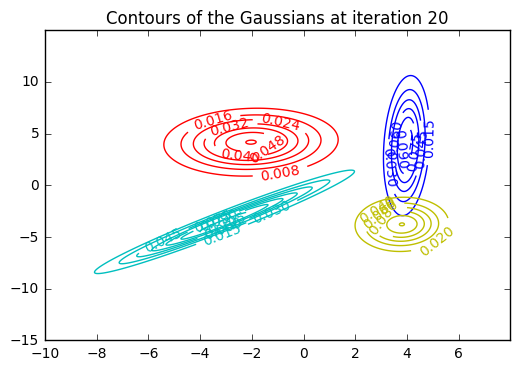

In [35]:
pi_20, mu_20, sigma_20 = EM_iterate(data_to_2d_array, pi_10, mu_10, sigma_10, 10)
draw_gaussian_contour(sigma_20, mu_20, 20)

# 4.(d) Comparison - Log-likelihood

log-likelihood $= \sum_{n = 1}^{N} log \sum_{i = 1}^{K} \pi_i Normal(x_n; \mu_i, \Sigma_i)$

In [36]:
def log_likelihood(data, pi, mu, sigma):
    result = 0
    for n in range(n_data):
        result += np.log(gamma(data[n], pi, mu, sigma)[0])
    return result

In [37]:
def EM_log_likelihood_special(data, pi_0, mu_0, sigma_0, n_iteration=10):
    pi_current = pi_0.copy()
    mu_current = mu_0.copy()
    sigma_current = sigma_0.copy()
    llh = []
    
    llh.append(log_likelihood(data, pi_current, mu_current, sigma_current))
    for i in range(n_iteration):
        pi_current, mu_current, sigma_current = EM_iterate_once_special(data, pi_current, mu_current, sigma_current)
        llh.append(log_likelihood(data, pi_current, mu_current, sigma_current))
                   
    return llh

In [38]:
def EM_log_likelihood(data, pi_0, mu_0, sigma_0, n_iteration=10):
    pi_current = pi_0.copy()
    mu_current = mu_0.copy()
    sigma_current = sigma_0.copy()
    llh = []
    
    llh.append(log_likelihood(data, pi_current, mu_current, sigma_current))
    for i in range(n_iteration):
        pi_current, mu_current, sigma_current = EM_iterate_once(data, pi_current, mu_current, sigma_current)
        llh.append(log_likelihood(data, pi_current, mu_current, sigma_current))
                   
    return llh

### Special Case

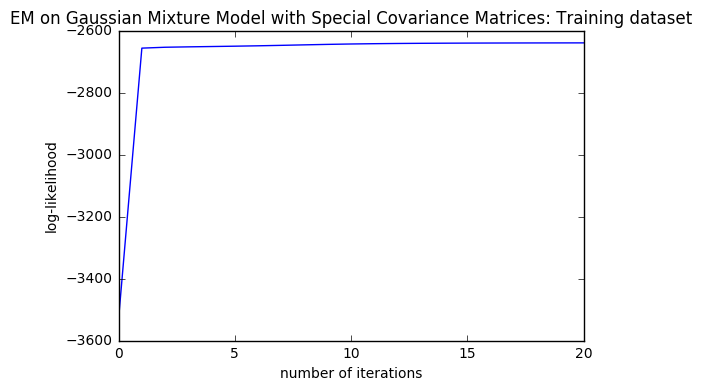

In [39]:
n_iter = 20
X = range(n_iter + 1)
Y = EM_log_likelihood_special(data_to_2d_array, pi_0, mu_0, sigma_0, n_iteration=n_iter)
plt.xlabel("number of iterations")
plt.ylabel("log-likelihood")
plt.title("EM on Gaussian Mixture Model with Special Covariance Matrices: Training dataset")
plt.plot(X, Y)
plt.show()

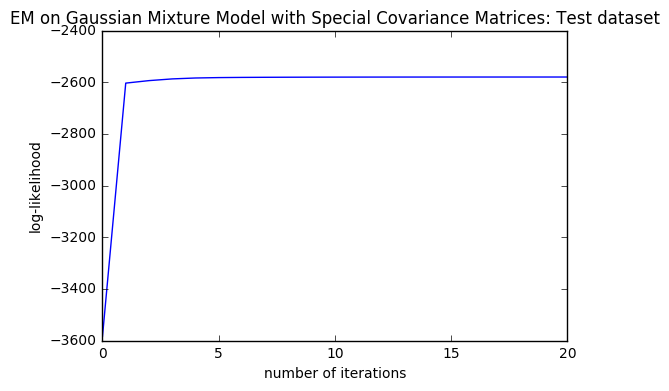

In [40]:
n_iter = 20
X = range(n_iter + 1)
Y = EM_log_likelihood_special(test_to_2d_array, pi_0, mu_0, sigma_0, n_iteration=n_iter)
plt.xlabel("number of iterations")
plt.ylabel("log-likelihood")
plt.title("EM on Gaussian Mixture Model with Special Covariance Matrices: Test dataset")
plt.plot(X, Y)
plt.show()

### General Case

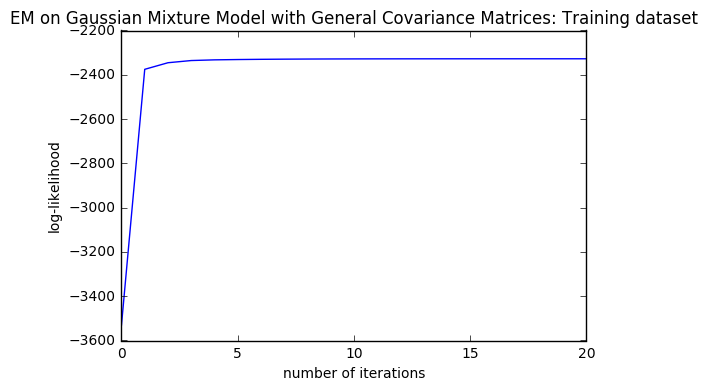

In [41]:
n_iter = 20
X = range(n_iter + 1)
Y = EM_log_likelihood(data_to_2d_array, pi_0, mu_0, sigma_0, n_iteration=n_iter)
plt.xlabel("number of iterations")
plt.ylabel("log-likelihood")
plt.title("EM on Gaussian Mixture Model with General Covariance Matrices: Training dataset")
plt.plot(X, Y)
plt.show()

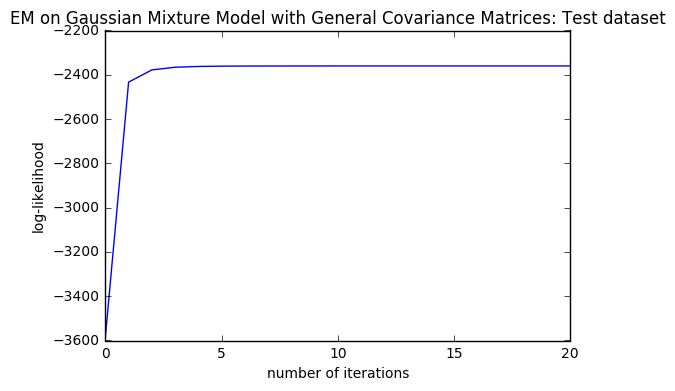

In [42]:
n_iter = 20
X = range(n_iter + 1)
Y = EM_log_likelihood(test_to_2d_array, pi_0, mu_0, sigma_0, n_iteration=n_iter)
plt.xlabel("number of iterations")
plt.ylabel("log-likelihood")
plt.title("EM on Gaussian Mixture Model with General Covariance Matrices: Test dataset")
plt.plot(X, Y)
plt.show()